# Dependencies

In [1]:
!pip install torch torchvision lightning torchmetrics
!pip install -U --no-deps pytorch-optimizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.4/562.4 kB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: starlette
    Found existing installation: starlette 0.26.1
    Uninstalling starlette-0.26.1:
      Successfully uninstalled starlette-0.26.1
  Attempting uninstall: fastapi
    Found existing installation: fastapi 0.95.1
    Uninstalling fastapi-0.95.1:
      Successfully uninstalled fastapi-0.95.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.1/127.1 kB 3.7 MB/s eta 0:00:00


In [2]:
from os import cpu_count
import random

import torch
from torch import nn, cat
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision.transforms as T
from torchvision.transforms.functional import to_tensor, to_pil_image, resize
from torchvision.utils import make_grid
import torchvision.models as models

import lightning.pytorch as pl
from torchmetrics import StructuralSimilarityIndexMeasure

from PIL import Image
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from pytorch_optimizer import Adan

random.seed(42)
torch.manual_seed(42)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Dataset

In [3]:
class NyuDataset(Dataset):
    def __init__(self, root, csv, apply_transforms=True):
        self.apply_transforms = apply_transforms
        with open(f'{root}{csv}') as f:
            self.samples = list(
                map(
                    lambda pair: list(
                        map(
                            lambda path: f'{root}{path}',
                            pair.strip().split(','),
                        )
                    ),
                    f.readlines(),
                )
            )

    def __getitem__(self, index):
        input_path, target_path = self.samples[index]
        input_image = Image.open(input_path)
        target_image = Image.open(target_path)
        x_tensor = to_tensor(input_image)
        y_tensor = to_tensor(target_image).float()
        y_tensor = y_tensor / y_tensor.max()
        # reduce the size to make the transforms less expensive
        x_tensor = resize(x_tensor, size=[224, 224], antialias=True)
        if self.apply_transforms:
            # reduce the targets to stack them later
            y_tensor = resize(y_tensor, size=[224, 224], antialias=True)
            input_image = T.ColorJitter()(input_image)
            t = T.Compose(
                [
                    T.RandomHorizontalFlip(),
                    T.ColorJitter(),
                    T.Normalize(0, 1)
                ]
            )
            # stack and apply the same transformations to both
            tensors = cat([x_tensor, y_tensor])
            tensors = t(tensors)
            x_tensor = tensors[0:3]
            y_tensor = tensors[3:]
        y_tensor = resize(y_tensor, size=[56, 56], antialias=True)
        return x_tensor, y_tensor

    def __len__(self):
        return len(self.samples)

In [4]:
class NyuDataModule(pl.LightningDataModule):
    def __init__(self, root, csv_train, csv_test, batch_size: int = 32, apply_transforms=True):
        super().__init__()
        dataset = NyuDataset(root, csv_train, apply_transforms)
        self.test = NyuDataset(root, csv_test, apply_transforms)
        proportions = [.7, .3]
        lengths = [int(p * len(dataset)) for p in proportions]
        lengths[-1] = len(dataset) - sum(lengths[:-1])
        self.train, self.val = random_split(dataset, lengths)
        self.batch_size = batch_size
        self.workers = cpu_count()

    def train_dataloader(self):
        return DataLoader(
            self.train,
            batch_size=self.batch_size,
            num_workers=self.workers,
            shuffle=True,
            drop_last=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.val,
            batch_size=self.batch_size,
            num_workers=self.workers,
            drop_last=True
        )

    def test_dataloader(self):
        return DataLoader(
            self.test,
            batch_size=self.batch_size,
            num_workers=self.workers,
        )


In [5]:
def visualize(name, batch, model=None, n=4):
    x, y = batch
    n = min(n, len(x))
    x = x[0:n]
    y = y[0:n]
    if model:
        fig, ax = plt.subplots(nrows=3, ncols=n)
    else:
        fig, ax = plt.subplots(nrows=2, ncols=n)
    fig.suptitle(name)
    for i, axi in enumerate(ax.flat):
        axi.axis(False)
        image = x[i % n]
        target = y[i % n].squeeze()
        if i < n:
            image = image.permute(1,2,0).cpu().numpy()
            axi.imshow((image * 255).astype(np.uint8), cmap='gray');
            if i % n == 0: axi.set_title('original image')
        elif i < 2*n:
            axi.imshow(target.cpu(), cmap='gray');
            if i % n == 0: axi.set_title('real depth')
        else:
            image = image.unsqueeze(0)
            estimated = model(image).detach().squeeze().squeeze()
            axi.imshow(estimated.cpu(), cmap='gray');
            if i % n == 0: axi.set_title('estimated depth')
    fig.tight_layout()
    return fig

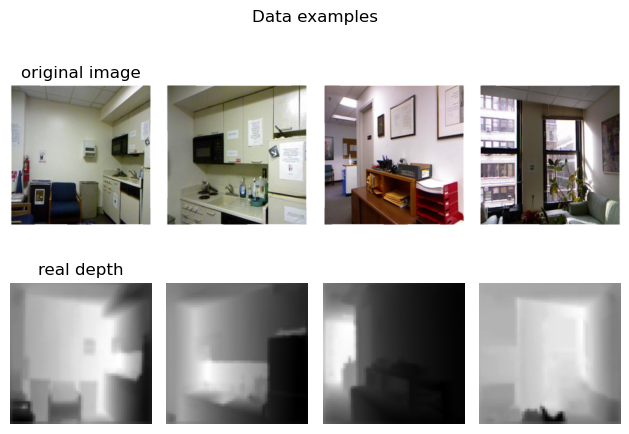

In [6]:
vis_data = NyuDataModule('/kaggle/input/nyu-depth-v2/nyu_data/', 'data/nyu2_train.csv', 'data/nyu2_test.csv',
                     batch_size=4, apply_transforms=True)
vis_batch = next(iter(vis_data.test_dataloader()))
visualize('Data examples', vis_batch);

# Model

In [7]:
class EfficientNetWrapper(pl.LightningModule):
    def __init__(self):
        super(EfficientNetWrapper, self).__init__()
        self.efficientnet = models.efficientnet_b0(
            weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1
        )
        self.base_layers = nn.Sequential(
            self.efficientnet.features[0],
            self.efficientnet.features[1],
            self.efficientnet.features[2],
        )
        self.layer1 = self.efficientnet.features[3]
        self.layer2 = nn.Sequential(
            self.efficientnet.features[4], self.efficientnet.features[5]
        )
        self.layer3 = self.efficientnet.features[6]
        self.layer4 = self.efficientnet.features[7]
        self.layer5 = self.efficientnet.features[8]

    def get_features(self, x):
        x = self.base_layers(x)
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        x5 = self.layer5(x4)
        return x1, x2, x3, x4, x5

In [8]:
class BiFPN(nn.Module):
    def __init__(self, fpn_sizes):
        super(BiFPN, self).__init__()

        (
            P3_channels,
            P4_channels,
            P5_channels,
            P6_channels,
            P7_channels,
        ) = fpn_sizes
        self.W_bifpn = 64

        # self.p6_td_conv  = nn.Conv2d(P6_channels, self.W_bifpn, kernel_size=3, stride=1, groups=self.W_bifpn, bias=True, padding=1)
        self.p6_td_conv = nn.Conv2d(
            P6_channels,
            self.W_bifpn,
            kernel_size=3,
            stride=1,
            bias=True,
            padding=1,
        )
        self.p6_td_conv_2 = nn.Conv2d(
            self.W_bifpn,
            self.W_bifpn,
            kernel_size=3,
            stride=1,
            groups=self.W_bifpn,
            bias=True,
            padding=1,
        )
        self.p6_td_act = nn.GELU() # RELU
        self.p6_td_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p6_td_w1 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p6_td_w2 = torch.tensor(1, dtype=torch.float, requires_grad=True)

        self.p5_td_conv = nn.Conv2d(
            P5_channels,
            self.W_bifpn,
            kernel_size=3,
            stride=1,
            bias=True,
            padding=1,
        )
        self.p5_td_conv_2 = nn.Conv2d(
            self.W_bifpn,
            self.W_bifpn,
            kernel_size=3,
            stride=1,
            groups=self.W_bifpn,
            bias=True,
            padding=1,
        )
        self.p5_td_act = nn.GELU() # RELU
        self.p5_td_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p5_td_w1 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p5_td_w2 = torch.tensor(1, dtype=torch.float, requires_grad=True)

        self.p4_td_conv = nn.Conv2d(
            P4_channels,
            self.W_bifpn,
            kernel_size=3,
            stride=1,
            bias=True,
            padding=1,
        )
        self.p4_td_conv_2 = nn.Conv2d(
            self.W_bifpn,
            self.W_bifpn,
            kernel_size=3,
            stride=1,
            groups=self.W_bifpn,
            bias=True,
            padding=1,
        )
        self.p4_td_act = nn.GELU() # RELU
        self.p4_td_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p4_td_w1 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p4_td_w2 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p5_upsample = nn.Upsample(scale_factor=2, mode='nearest')

        self.p3_out_conv = nn.Conv2d(
            P3_channels,
            self.W_bifpn,
            kernel_size=3,
            stride=1,
            bias=True,
            padding=1,
        )
        self.p3_out_conv_2 = nn.Conv2d(
            self.W_bifpn,
            self.W_bifpn,
            kernel_size=3,
            stride=1,
            groups=self.W_bifpn,
            bias=True,
            padding=1,
        )
        self.p3_out_act = nn.GELU() # RELU
        self.p3_out_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p3_out_w1 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p3_out_w2 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p4_upsample = nn.Upsample(scale_factor=2, mode='nearest')

        # self.p4_out_conv = nn.Conv2d(P4_channels, self.W_bifpn, kernel_size=3, stride=1, bias=True, padding=1)
        self.p4_out_conv = nn.Conv2d(
            self.W_bifpn,
            self.W_bifpn,
            kernel_size=3,
            stride=1,
            groups=self.W_bifpn,
            bias=True,
            padding=1,
        )
        self.p4_out_act = nn.GELU() # RELU
        self.p4_out_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p4_out_w1 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p4_out_w2 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p4_out_w3 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p3_downsample = nn.MaxPool2d(kernel_size=2)

        # self.p5_out_conv = nn.Conv2d(P5_channels,self.W_bifpn, kernel_size=3, stride=1, bias=True, padding=1)
        self.p5_out_conv = nn.Conv2d(
            self.W_bifpn,
            self.W_bifpn,
            kernel_size=3,
            stride=1,
            groups=self.W_bifpn,
            bias=True,
            padding=1,
        )
        self.p5_out_act = nn.GELU() # RELU
        self.p5_out_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p5_out_w1 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p5_out_w2 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p5_out_w3 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p4_downsample = nn.MaxPool2d(kernel_size=2)

        # self.p6_out_conv = nn.Conv2d(P6_channels, self.W_bifpn, kernel_size=3, stride=1, bias=True, padding=1)
        self.p6_out_conv = nn.Conv2d(
            self.W_bifpn,
            self.W_bifpn,
            kernel_size=3,
            stride=1,
            groups=self.W_bifpn,
            bias=True,
            padding=1,
        )
        self.p6_out_act = nn.GELU() # RELU
        self.p6_out_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p6_out_w1 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p6_out_w2 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p6_out_w3 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        # self.p4_downsample= nn.MaxPool2d(kernel_size=2)

        self.p7_out_conv = nn.Conv2d(
            P7_channels,
            self.W_bifpn,
            kernel_size=3,
            stride=1,
            bias=True,
            padding=1,
        )
        self.p7_out_conv_2 = nn.Conv2d(
            self.W_bifpn,
            self.W_bifpn,
            kernel_size=3,
            stride=1,
            groups=self.W_bifpn,
            bias=True,
            padding=1,
        )
        self.p7_out_act = nn.GELU() # RELU
        self.p7_out_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p7_out_w1 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p7_out_w2 = torch.tensor(1, dtype=torch.float, requires_grad=True)

    def forward(self, inputs):
        epsilon = 0.0001
        P3, P4, P5, P6, P7 = inputs
        # print ("Input::", P3.shape, P4.shape, P5.shape, P6.shape, P7.shape)
        # P6_td = self.p6_td_conv((self.p6_td_w1 * P6 ) /
        #                         (self.p6_td_w1 + epsilon))

        P7_td = self.p7_out_conv(P7)

        P6_td_inp = self.p6_td_conv(P6)
        P6_td = self.p6_td_conv_2(
            (self.p6_td_w1 * P6_td_inp + self.p6_td_w2 * P7_td) / self.p6_td_w1
            + self.p6_td_w2
            + epsilon
        )
        # P6_td = self.p6_td_conv_2(P6_td_inp)
        P6_td = self.p6_td_act(P6_td)
        P6_td = self.p6_td_conv_bn(P6_td)

        P5_td_inp = self.p5_td_conv(P5)
        # print (P5_td_inp.shape, P6_td.shape)
        P5_td = self.p5_td_conv_2(
            (self.p5_td_w1 * P5_td_inp + self.p5_td_w2 * P6_td)
            / (self.p5_td_w1 + self.p5_td_w2 + epsilon)
        )
        P5_td = self.p5_td_act(P5_td)
        P5_td = self.p5_td_conv_bn(P5_td)

        # print (P4.shape, P5_td.shape)
        P4_td_inp = self.p4_td_conv(P4)
        P4_td = self.p4_td_conv_2(
            (
                self.p4_td_w1 * P4_td_inp
                + self.p4_td_w2 * self.p5_upsample(P5_td)
            )
            / (self.p4_td_w1 + self.p4_td_w2 + epsilon)
        )
        P4_td = self.p4_td_act(P4_td)
        P4_td = self.p4_td_conv_bn(P4_td)

        P3_td = self.p3_out_conv(P3)
        P3_out = self.p3_out_conv_2(
            (self.p3_out_w1 * P3_td + self.p3_out_w2 * self.p4_upsample(P4_td))
            / (self.p3_out_w1 + self.p3_out_w2 + epsilon)
        )
        P3_out = self.p3_out_act(P3_out)
        P3_out = self.p3_out_conv_bn(P3_out)

        # print (P4_td.shape, P3_out.shape)

        P4_out = self.p4_out_conv(
            (
                self.p4_out_w1 * P4_td_inp
                + self.p4_out_w2 * P4_td
                + self.p4_out_w3 * self.p3_downsample(P3_out)
            )
            / (self.p4_out_w1 + self.p4_out_w2 + self.p4_out_w3 + epsilon)
        )
        P4_out = self.p4_out_act(P4_out)
        P4_out = self.p4_out_conv_bn(P4_out)

        P5_out = self.p5_out_conv(
            (
                self.p5_out_w1 * P5_td_inp
                + self.p5_out_w2 * P5_td
                + self.p5_out_w3 * self.p4_downsample(P4_out)
            )
            / (self.p5_out_w2 + self.p5_out_w3 + epsilon)
        )
        P5_out = self.p5_out_act(P5_out)
        P5_out = self.p5_out_conv_bn(P5_out)

        P6_out = self.p6_out_conv(
            (
                self.p6_out_w1 * P6_td_inp
                + self.p6_out_w2 * P6_td
                + self.p6_out_w3 * (P5_out)
            )
            / (self.p6_out_w1 + self.p6_out_w2 + self.p6_out_w3 + epsilon)
        )
        P6_out = self.p6_out_act(P6_out)
        P6_out = self.p6_out_conv_bn(P6_out)

        P7_out = self.p7_out_conv_2(
            (self.p7_out_w1 * P7_td + self.p7_out_w2 * P6_out)
            / (self.p7_out_w1 + self.p7_out_w2 + epsilon)
        )
        P7_out = self.p7_out_act(P7_out)
        P7_out = self.p7_out_conv_bn(P7_out)

        return [P3_out, P4_out, P5_out, P6_out, P7_out]

In [9]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.bifpn = BiFPN([40, 112, 192, 320, 1280])
        self.upsample1 = nn.PixelShuffle(2)
        self.upsample2 = nn.PixelShuffle(4)
        self.bn = nn.BatchNorm2d(20)
        self.act = nn.GELU()

    def forward(self, x):
        x1, x2, _, _, _ = self.bifpn(x)
        x1 = self.upsample1(x1)
        x2 = self.upsample2(x2)
        x = torch.cat([x1, x2], 1)
        x = self.bn(x)
        x = self.act(x)
        return x

In [10]:
class ConvBlock(nn.Module):
    def __init__(self, in_dims, out_dims, kernel_size=3, extras=True):
        super().__init__()
        self.depth_conv = nn.Conv2d(in_dims, in_dims, kernel_size=kernel_size, padding=kernel_size//2, groups=in_dims)
        self.point_conv = nn.Conv2d(in_dims, out_dims, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_dims) if extras else None
        self.act = nn.GELU() if extras else None

    def forward(self, x):
        x = self.depth_conv(x)
        x = self.point_conv(x)
        if self.bn:
            x = self.bn(x)
            x = self.act(x)
        return x

In [11]:
class InceptionCore(nn.Module):
    def __init__(self, in_dims, base=16):
        super().__init__()
        self.branch_1_1 = nn.Conv2d(in_dims, base, 1)
        self.branch_1_3 = nn.Conv2d(base, base*2, 3, padding=1)
        self.branch_1_13 = nn.Conv2d(base*2, base*3, (1,3), padding=(0,1))
        self.branch_1_31 = nn.Conv2d(base*2, base*3, (3,1), padding=(1,0))

        self.branch_2_1 = nn.Conv2d(in_dims, base, 1)
        self.branch_2_13 = nn.Conv2d(base, base*2, (1,3), padding=(0,1))
        self.branch_2_31 = nn.Conv2d(base, base*2, (3,1), padding=(1,0))
        
        self.branch_3_1 = nn.Conv2d(in_dims, base, 1)
        
        self.downsample = nn.Conv2d(in_dims, base*11, 1, bias=False)

    def forward(self, x):
        branch_1 = self.branch_1_1(x)
        branch_1 = self.branch_1_3(branch_1)
        branch_1_1 = self.branch_1_13(branch_1)
        branch_1_2 = self.branch_1_31(branch_1)

        branch_2 = self.branch_2_1(x)
        branch_2_1 = self.branch_2_13(branch_2)
        branch_2_2 = self.branch_2_31(branch_2)

        branch_3 = self.branch_3_1(x)

        res = self.downsample(x)

        x = torch.cat([branch_1_1, branch_1_2, branch_2_1, branch_2_2, branch_3], dim=1)
        x += res
        
        return x

In [12]:
class DepthNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = EfficientNetWrapper()
        self.encoder.freeze()
        self.d1 = Decoder()
        self.d2 = Decoder()
        self.d3 = Decoder()
        self.downsample = nn.Sequential(
            nn.Conv2d(3, 60, 1, bias=False),
            nn.MaxPool2d(4)
        )
        self.downsample2 = nn.Sequential(
            nn.Conv2d(3, 1, 1, bias=False),
            nn.MaxPool2d(4)
        )
        self.head = nn.Sequential(
            InceptionCore(60),
            ConvBlock(176, 40),
            ConvBlock(40, 1, extras=False),
        )
        self.act = nn.Sigmoid()

    def forward(self, x):
        res1 = self.downsample(x)
        res2 = self.downsample2(x)
        x = self.encoder.get_features(x)
        x1 = self.d1(x)
        x2 = self.d2(x)
        x3 = self.d3(x)
        x = cat([x1, x2, x3], 1)
        x += res1
        x = self.head(x)
        x += res2
        x = self.act(x)
        return x

# Module definition

In [13]:
class LitDepth(pl.LightningModule):
    def __init__(self, learning_rate=2e-3, weight_decay=1e-6):
        super(LitDepth, self).__init__()
        self.save_hyperparameters()
        self.net = DepthNet()
        self.loss = torch.nn.MSELoss()
        self.accuracy = StructuralSimilarityIndexMeasure(data_range=1.0)

    def forward(self, x):
        x = self.net(x)
        return x

    def _do_stuff(self, batch, name):
        x, y = batch
        estimated = self(x)
        acc = self.accuracy(estimated, y)
        self.log(f'{name}_acc', acc)
        loss = self.loss(estimated, y)
        self.log(f'{name}_loss', loss)
        return loss

    def training_step(self, batch, _batch_idx):
        return self._do_stuff(batch, 'train')

    def validation_step(self, batch, _batch_idx):
        loss = self._do_stuff(batch, 'validation')
        self.log('hp_metric', loss)
        return loss

    def test_step(self, batch, _batch_idx):
        return self._do_stuff(batch, 'test')

    def configure_optimizers(self):
        lr = self.hparams.learning_rate
        wd = self.hparams.weight_decay
        optimizer = Adan(self.parameters(), lr=lr, weight_decay=wd)
        return optimizer


# Training

## Image callback

In [14]:
class ImageSampler(pl.callbacks.Callback):
    def __init__(
        self,
        num_samples: int = 3,
        nrow: int = 8,
        padding: int = 2,
        normalize: bool = True,
        norm_range = None,
        scale_each: bool = False,
        pad_value: int = 0,
    ) -> None:
        """
        Args:
            num_samples: Number of images displayed in the grid. Default: ``3``.
            nrow: Number of images displayed in each row of the grid.
                The final grid size is ``(B / nrow, nrow)``. Default: ``8``.
            padding: Amount of padding. Default: ``2``.
            normalize: If ``True``, shift the image to the range (0, 1),
                by the min and max values specified by :attr:`range`. Default: ``False``.
            norm_range: Tuple (min, max) where min and max are numbers,
                then these numbers are used to normalize the image. By default, min and max
                are computed from the tensor.
            scale_each: If ``True``, scale each image in the batch of
                images separately rather than the (min, max) over all images. Default: ``False``.
            pad_value: Value for the padded pixels. Default: ``0``.
        """
        super().__init__()
        self.num_samples = num_samples
        self.nrow = nrow
        self.padding = padding
        self.normalize = normalize
        self.norm_range = norm_range
        self.scale_each = scale_each
        self.pad_value = pad_value
        
    def to_grid(self, images):
        return make_grid(
            tensor=images,
            nrow=self.nrow,
            padding=self.padding,
            normalize=self.normalize,
            range=self.norm_range,
            scale_each=self.scale_each,
            pad_value=self.pad_value,
        )

    def on_fit_start(self, trainer, pl_module):
        logger = pl_module.logger.experiment
        images, ground_truth = next(iter(DataLoader(trainer.datamodule.val, batch_size=self.num_samples)))
        # image_grid = self.to_grid(images)
        # target_grid = self.to_grid(targets)
        logger.add_images("original images", images)
        logger.add_images("real depth", ground_truth)

    def on_validation_epoch_end(self, trainer, pl_module) -> None:
        logger = pl_module.logger.experiment
        images, targets = next(iter(DataLoader(trainer.datamodule.val, batch_size=self.num_samples)))
        # generate images
        estimated = pl_module(images.to(pl_module.device)).detach()
        # estimated_grid = to_pil_image(self.to_grid(estimated))
        logger.add_images("estimated depth", estimated, trainer.current_epoch)
        
    def on_test_epoch_end(self, trainer, pl_module) -> None:
        logger = pl_module.logger.experiment
        images, targets = next(iter(DataLoader(trainer.datamodule.test, batch_size=self.num_samples)))
        # generate images
        estimated = pl_module(images.to(pl_module.device)).detach()
        # estimated_grid = to_pil_image(self.to_grid(estimated))
        logger.add_images("test images", images)
        logger.add_images("test estimation", estimated)

## Experiment definitions

In [15]:
experiments = [{
    'name': 'low_lr_with_augs',
    'lr': 2e-4,
    'augs': True
    },
    {
    'name': 'mid_lr_with_augs',
    'lr': 2e-3,
    'augs': True
    },
    {
    'name': 'high_lr_with_augs',
    'lr': 2e-2,
    'augs': True
    },
    {
    'name': 'without_augs',
    'lr': 2e-3,
    'augs': False
}]

## Trainer Definition

In [16]:
def run_experiment(name, lr, augs):
    early_stop_callback = pl.callbacks.EarlyStopping(
      monitor='validation_loss',
      min_delta=1e-3,
      patience=4,
      mode='min'
    )

    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath='/kaggle/working/models/',
        filename=f'best_model_{name}',
        save_top_k=1,
        monitor='validation_loss',
        mode='min',
    )
    
    tb_logger = pl.loggers.TensorBoardLogger(
        save_dir='/kaggle/working/',
        name='tb_logs',
        version=name
    )

    data = NyuDataModule(
        root='/kaggle/input/nyu-depth-v2/nyu_data/',
        csv_train='data/nyu2_train.csv',
        csv_test='data/nyu2_test.csv',
        batch_size=32,
        apply_transforms=augs
    )

    model = LitDepth(learning_rate = lr)

    trainer = pl.Trainer(
        default_root_dir='/kaggle/working/',
        callbacks=[
            early_stop_callback,
            checkpoint_callback,
            ImageSampler(),
            pl.callbacks.LearningRateMonitor(),
            pl.callbacks.ModelSummary(),
        ],
        max_epochs=15,
        precision=16,
        logger=tb_logger,
        gradient_clip_val=0.5,
        # limit_train_batches=8,
        # limit_test_batches=8,
        # limit_val_batches=8,
        # detect_anomaly=True,
        # fast_dev_run=True,
        # profiler="simple"
    )

    print('Starting training...')
    trainer.fit(model, datamodule=data)

    print('Starting testing...')
    trainer.test(model, datamodule=data)
    
    model.eval()
    model.freeze()
    vis_batch = next(iter(data.train_dataloader()))
    visualize(f'{name} estimation', vis_batch, model);

# Runs

Running experiment 1/4: {'name': 'low_lr_with_augs', 'lr': 0.0002, 'augs': True}


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 39.5MB/s]
/opt/conda/lib/python3.10/site-packages/lightning/fabric/connector.py:562: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs


Starting training...


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type                             | Params
--------------------------------------------------------------
0 | net      | DepthNet                         | 8.7 M 
1 | loss     | MSELoss                          | 0     
2 | accuracy | StructuralSimilarityIndexMeasure | 0     
--------------------------------------------------------------
3.4 M     Trainable params
5.3 M     Non-trainable params
8.7 M     Total params
34.830    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting testing...


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6155616044998169     │
│         test_loss         │   0.023416046053171158    │
└───────────────────────────┴───────────────────────────┘

Running experiment 2/4: {'name': 'mid_lr_with_augs', 'lr': 0.002, 'augs': True}


/opt/conda/lib/python3.10/site-packages/lightning/fabric/connector.py:562: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /kaggle/working/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting training...


INFO: 
  | Name     | Type                             | Params
--------------------------------------------------------------
0 | net      | DepthNet                         | 8.7 M 
1 | loss     | MSELoss                          | 0     
2 | accuracy | StructuralSimilarityIndexMeasure | 0     
--------------------------------------------------------------
3.4 M     Trainable params
5.3 M     Non-trainable params
8.7 M     Total params
34.830    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting testing...


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6282714605331421     │
│         test_loss         │   0.023020191118121147    │
└───────────────────────────┴───────────────────────────┘

Running experiment 3/4: {'name': 'high_lr_with_augs', 'lr': 0.02, 'augs': True}


INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting training...


INFO: 
  | Name     | Type                             | Params
--------------------------------------------------------------
0 | net      | DepthNet                         | 8.7 M 
1 | loss     | MSELoss                          | 0     
2 | accuracy | StructuralSimilarityIndexMeasure | 0     
--------------------------------------------------------------
3.4 M     Trainable params
5.3 M     Non-trainable params
8.7 M     Total params
34.830    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting testing...


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5843579769134521     │
│         test_loss         │   0.023664213716983795    │
└───────────────────────────┴───────────────────────────┘

Running experiment 4/4: {'name': 'without_augs', 'lr': 0.002, 'augs': False}


INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting training...


INFO: 
  | Name     | Type                             | Params
--------------------------------------------------------------
0 | net      | DepthNet                         | 8.7 M 
1 | loss     | MSELoss                          | 0     
2 | accuracy | StructuralSimilarityIndexMeasure | 0     
--------------------------------------------------------------
3.4 M     Trainable params
5.3 M     Non-trainable params
8.7 M     Total params
34.830    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting testing...


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6211340427398682     │
│         test_loss         │    0.02405804768204689    │
└───────────────────────────┴───────────────────────────┘

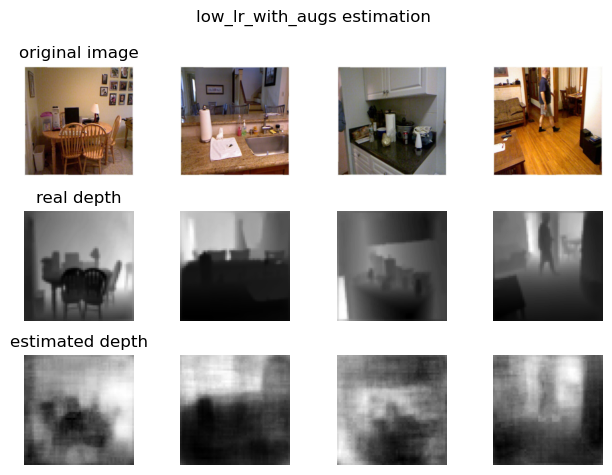

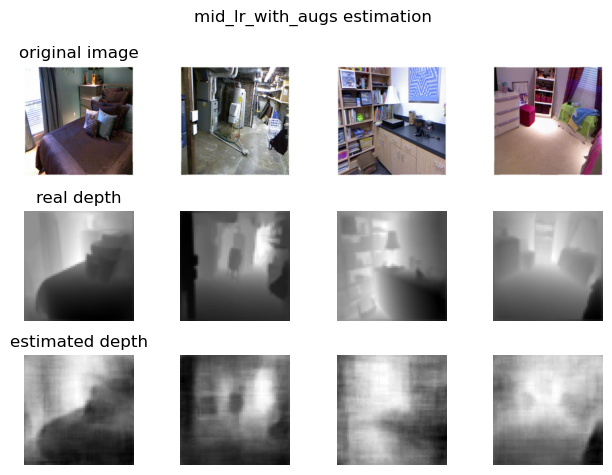

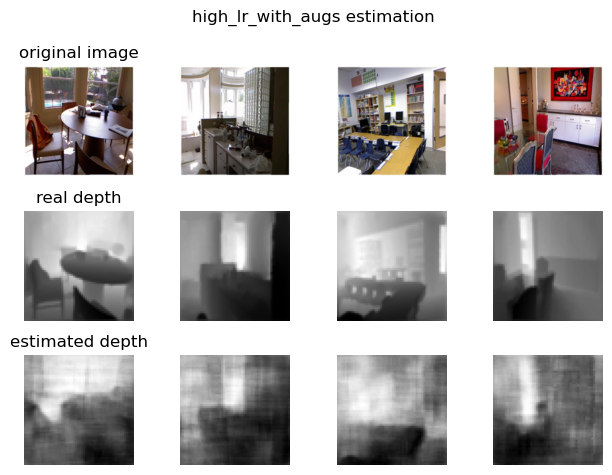

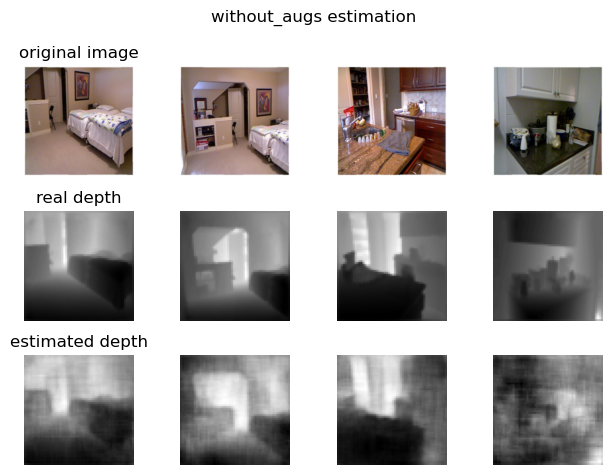

In [17]:
for (i, exp) in enumerate(experiments):
    print(f'Running experiment {i+1}/{len(experiments)}:', exp)
    run_experiment(**exp)